In [89]:
import cg_rag

# baselines retrievers module
import cg_rag.baselines.retrievers as R
dir(R)

['BM25Okapi',
 'BM25Retriever',
 'DenseRetriever',
 'Embedder',
 'List',
 'Optional',
 'RetrievalResult',
 'Segment',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'np']

In [90]:
import inspect
print(inspect.getsource(R.DenseRetriever))

class DenseRetriever:
    """Simple dense retrieval baseline using cosine similarity."""

    def __init__(self, segments: List[Segment], embedder: Embedder, top_k: int = 3):
        self.segments = segments
        self.embedder = embedder
        self.top_k = top_k

        self.U = np.array([s.vector for s in segments])
        norms = np.linalg.norm(self.U, axis=1, keepdims=True)
        self.U_norm = self.U / np.maximum(norms, 1e-10)

    def _get_scores(self, query: str) -> np.ndarray:
        query_emb = self.embedder.embed([query], show_progress=False)[0]
        query_norm = np.linalg.norm(query_emb)
        query_normalized = query_emb / query_norm if query_norm > 1e-10 else query_emb
        return np.dot(self.U_norm, query_normalized)

    def retrieve(self, query: str, verbose: bool = False) -> RetrievalResult:
        scores = self._get_scores(query)
        top_indices = np.argsort(scores)[::-1][:self.top_k]

        return RetrievalResult(
            segments=[self.seg

In [91]:
#importing data
from beir import util
from beir.datasets.data_loader import GenericDataLoader
data_path = util.download_and_unzip( "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/scifact.zip","./datasets")

corpus, queries, qrels = GenericDataLoader(data_path).load(split="test")
len(corpus), len(queries)

  0%|          | 0/5183 [00:00<?, ?it/s]

(5183, 300)

In [92]:
# exploring dataset
print("Num documents:", len(corpus))
print("Num queries:", len(queries))
print("Num qrels:", len(qrels))
import random

doc_id = random.choice(list(corpus.keys()))
doc = corpus[doc_id]

print("Doc ID:", doc_id)
print("Title:", doc.get("title", "N/A"))
print("Text:\n", doc["text"][:1000])

Num documents: 5183
Num queries: 300
Num qrels: 300
Doc ID: 28697248
Title: E2F3 is a mediator of DNA damage-induced apoptosis.
Text:
 The E2F transcription factors have emerged as critical apoptotic effectors. Herein we report that the E2F family member E2F3a can be induced by DNA damage through transcriptional and posttranslational mechanisms. We demonstrate that the posttranslational induction of human E2F3a is dependent on the checkpoint kinases. Moreover, we show that human E2F3a is a substrate for the checkpoint kinases (chk kinases) and that mutation of the chk phosphorylation site eliminates the DNA damage inducibility of the protein. Furthermore, we demonstrate that E2F1 and E2F2 are transcriptionally induced by DNA damage in an E2f3-dependent manner. Finally, using both in vitro and in vivo approaches, we establish that E2f3 is required for DNA damage-induced apoptosis. Thus, our data reveal the novel ability of E2f3 to function as a master regulator of the DNA damage respons

In [93]:
#exploring what an example query asks and what counts as correct 
#chooses random query and its respective relevant documents each time
qid = random.choice(list(queries.keys()))

print("Query ID:", qid)
print("Query:", queries[qid])
print("\nRelevant docs:")

for did in qrels[qid]:
    print("Doc:", did)
    print(corpus[did]["text"][:500])
    print("-"*60)
    



Query ID: 1012
Query: Radioiodine treatment of non-toxic multinodular goitre reduces thyroid volume.

Relevant docs:
Doc: 9745001
OBJECTIVE To investigate the long term effect of radioactive iodine on thyroid function and size in patients with non-toxic multinodular goitre. DESIGN Consecutive patients with multinodular non-toxic goitre selected for radioactive iodine treatment and followed for a minimum of 12 months (median 48 months) after an intended dose of 3.7 MBq/g thyroid tissue corrected to a 100% uptake of iodine-131 in 24 hours. PATIENTS 69 patients with a growing multinodular non-toxic goitre causing local compre
------------------------------------------------------------


In [94]:
import numpy as np

rel_counts = [len(qrels[q]) for q in qrels]

print("Min:", min(rel_counts))
print("Max:", max(rel_counts))
print("Mean:", np.mean(rel_counts))

Min: 1
Max: 5
Mean: 1.13


In [95]:
import cg_rag.models.embedding as E
dir(E)

['Embedder',
 'List',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'np',
 'torch']

In [96]:
# this the embedder i will use
print(inspect.getsource(E.Embedder))

class Embedder:
    """Wrapper for sentence-transformers embedding models."""

    def __init__(self, model_name: str = None):
        from sentence_transformers import SentenceTransformer

        # 1. Hardware Detection & Model Selection
        if torch.cuda.is_available():
            self.device = "cuda"
            # High-performance, large-context embedding model
            #default_model = 'Alibaba-NLP/gte-Qwen2-7B-instruct'
            default_model = 'all-MiniLM-L6-v2' # use this for debugging, is super fast
            print(f"GPU detected. Using high-fidelity embedder: {default_model}")
        else:
            self.device = "cpu"
            # Lightweight, highly efficient model for CPU
            #default_model = 'Alibaba-NLP/gte-Qwen2-1.5B-instruct'
            default_model = 'all-MiniLM-L6-v2' # use this for debugging, is super fast
            print(f"No GPU found. Using lightweight CPU embedder: {default_model}")

        self.model_name = model_name or default_mo

In [97]:
#creating segments stuff, trying to figure out the signature
import numpy as np
from beir import util
from beir.datasets.data_loader import GenericDataLoader
import cg_rag.baselines.retrievers as R
import cg_rag.models.embedding as E
import cg_rag.structures as S  # contains Segment, RetrievalResult, etc.
import inspect
print("Segment signature:", inspect.signature(S.Segment))
print("Segment annotations:", getattr(S.Segment, "__annotations__", None))

Segment signature: (text: str, vector: numpy.ndarray, start_idx: int, end_idx: int, sentences: List[str] = <factory>, internal_cost: float = 0.0) -> None
Segment annotations: {'text': <class 'str'>, 'vector': <class 'numpy.ndarray'>, 'start_idx': <class 'int'>, 'end_idx': <class 'int'>, 'sentences': typing.List[str], 'internal_cost': <class 'float'>}


In [98]:
data_path = util.download_and_unzip(
    "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/scifact.zip",
    "./datasets"
)
corpus, queries, qrels = GenericDataLoader(data_path).load(split="test")
print("corpus:", len(corpus), "queries:", len(queries))

  0%|          | 0/5183 [00:00<?, ?it/s]

corpus: 5183 queries: 300


In [99]:
#testing out what the docs look like
doc_ids = list(corpus.keys())
doc_texts = [
    (corpus[doc_id].get("title","") + " " + corpus[doc_id].get("text","")).strip()
    for doc_id in doc_ids
]
print("Example doc:", doc_ids[0], doc_texts[0][:200])

Example doc: 4983 Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion tensor magnetic resonance imaging. Alterations of the architecture of cerebral white matter in the deve


In [100]:
#embedding every document
embedder = E.Embedder() 
doc_vectors = embedder.embed(doc_texts, batch_size=64, show_progress=True)
print("doc_vectors shape:", doc_vectors.shape)

No GPU found. Using lightweight CPU embedder: all-MiniLM-L6-v2
Loading embedding model: None
Embedder ready (dim=384)


Batches:   0%|          | 0/81 [00:00<?, ?it/s]

doc_vectors shape: (5183, 384)


In [101]:
segments = []
segment_doc_ids = [] # same length as segments
for i, (doc_id, text, vec) in enumerate(zip(doc_ids, doc_texts, doc_vectors)):
    seg = S.Segment(
    text=text,
    vector=vec,
    start_idx=i,
    end_idx=i+1,
    sentences=[], # optional
    internal_cost=0.0 # optional
    )
    segments.append(seg)
    segment_doc_ids.append(doc_id)
# Map python object identity -> index, so we can recover doc_id later
seg_id_to_idx = {id(seg): i for i, seg in enumerate(segments)}
print("segments:", len(segments))
print("example:", segments[0].start_idx, segments[0].end_idx, segment_doc_ids[0])

segments: 5183
example: 0 1 4983


In [102]:
dense = R.DenseRetriever(segments=segments, embedder=embedder, top_k=10)

In [103]:
def is_hit_at_k(retrieved_doc_ids, qrel_dict):
    gold = set(qrel_dict.keys())
    return any(d in gold for d in retrieved_doc_ids)

hits = []
dense_fail_qids = []

for qid, qtext in queries.items():
    result = dense.retrieve(qtext)  # RetrievalResult

    # Convert retrieved segments to their respective doc_ids
    retrieved_doc_ids = []
    for seg in result.segments:
        idx = seg_id_to_idx[id(seg)]
        retrieved_doc_ids.append(segment_doc_ids[idx])

    hit = is_hit_at_k(retrieved_doc_ids, qrels.get(qid, {}))
    hits.append(hit)
    if not hit:
        dense_fail_qids.append(qid)

print(f"Dense hit@10: {sum(hits)}/{len(hits)} = {sum(hits)/len(hits):.3f}")
print("Dense failures:", len(dense_fail_qids))
dense_fail_qids[:20]

Dense hit@10: 238/300 = 0.793
Dense failures: 62


['13',
 '48',
 '70',
 '128',
 '132',
 '198',
 '239',
 '294',
 '303',
 '312',
 '314',
 '384',
 '415',
 '421',
 '431',
 '437',
 '475',
 '502',
 '508',
 '517']

In [104]:
import pandas as pd

rows = []

for qid in dense_fail_qids:
    rows.append({
        "qid": qid,
        "query": queries[qid],
        "label": "",
        "notes": ""
    })

dense_fail_df = pd.DataFrame(rows)
dense_fail_df.head(10)

,qid,query,label,notes
0,13,5% of perinatal mortality is due to low birth weight.,,
1,48,"A total of 1,000 people in the UK are asymptomatic carriers of vCJD infection.",,
2,70,Activation of PPM1D suppresses p53 function.,,
3,128,Arterioles have a larger lumen diameter than venules.,,
4,132,Aspirin inhibits the production of PGE2.,,
5,198,CCL19 is absent within dLNs.,,
6,239,Cellular aging closely links to an older appearance.,,
7,294,Crossover hot spots are not found within gene promoters in Saccharomyces cerevisiae.,,
8,303,DMRT1 is a sex-determining gene that is epigenetically regulated by the MHM region.,,
9,312,De novo assembly of sequence data has more specific contigs than unassembled sequence data.,,


In [105]:
import pandas as pd

def dense_failure_row(qid, k=5):
    qtext = queries[qid]
    gold_ids = list(qrels.get(qid, {}).keys())

    result = dense.retrieve(qtext)
    top_ids = [
        segment_doc_ids[seg_id_to_idx[id(s)]]
        for s in result.segments[:k]
    ]

    # short snippets so it’s readable
    top_snips = []
    for doc_id in top_ids:
        txt = (corpus[doc_id].get("title","") + " " + corpus[doc_id].get("text",""))[:300]
        top_snips.append({"doc_id": doc_id, "snippet": txt})

    gold_snips = []
    for doc_id in gold_ids[:3]:
        txt = (corpus[doc_id].get("title","") + " " + corpus[doc_id].get("text",""))[:300]
        gold_snips.append({"doc_id": doc_id, "snippet": txt})

    return {
        "qid": qid,
        "query": qtext,
        "gold_ids": gold_ids,
        "gold_preview": gold_snips,
        "dense_top_ids": top_ids,
        "dense_top_preview": top_snips,
    }

dense_fail_payload = [dense_failure_row(qid, k=5) for qid in dense_fail_qids]
df = pd.DataFrame(dense_fail_payload)
df.head()
df.to_json("dense_fail_payload.jsonl", orient="records", lines=True)


In [106]:
def inspect_dense_fail(qid, k=5):
    qtext = queries[qid]
    gold_ids = list(qrels.get(qid, {}).keys())

    result = dense.retrieve(qtext)
    retrieved = [
        segment_doc_ids[seg_id_to_idx[id(s)]]
        for s in result.segments[:k]
    ]

    print("="*70)
    print("QID:", qid)
    print("QUERY:", qtext)
    print("GOLD DOC IDS:", gold_ids[:5])

    print("\nTOP DENSE RESULTS:")
    for i, doc_id in enumerate(retrieved, 1):
        text = (
            corpus[doc_id].get("title","") +
            " " +
            corpus[doc_id].get("text","")
        )[:250]
        print(f"{i}. {doc_id} | {text}...")

    print("="*70)

In [107]:
for qid in dense_fail_qids:
    inspect_dense_fail(qid)

QID: 13
QUERY: 5% of perinatal mortality is due to low birth weight.
GOLD DOC IDS: ['1606628']

TOP DENSE RESULTS:
1. 7662395 | Perinatal mortality in rural China: retrospective cohort study. OBJECTIVES To explore the use of local civil registration data to assess the perinatal mortality in a typical rural county in a less developed province in China, 1999-2000. DESIGN Retros...
2. 4791384 | Neonatal Mortality Levels for 193 Countries in 2009 with Trends since 1990: A Systematic Analysis of Progress, Projections, and Priorities BACKGROUND Historically, the main focus of studies of childhood mortality has been the infant and under-five mo...
3. 1263446 | Determinants of neonatal mortality in Indonesia BACKGROUND Neonatal mortality accounts for almost 40 per cent of under-five child mortality, globally. An understanding of the factors related to neonatal mortality is important to guide the development...
4. 11748341 | Evidence-based interventions for improvement of maternal and child nut

In [108]:
rows = []

for qid in dense_fail_qids:
    qtext = queries[qid]
    gold_ids = list(qrels[qid].keys())

    result = dense.retrieve(qtext)
    retrieved_ids = [
        segment_doc_ids[seg_id_to_idx[id(s)]]
        for s in result.segments[:5]
    ]

    rows.append({
        "qid": qid,
        "query": qtext,
        "gold_ids": gold_ids,
        "top_retrieved_ids": retrieved_ids
    })
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

fail_table = pd.DataFrame(rows)
fail_table


,qid,query,gold_ids,top_retrieved_ids
0,13,5% of perinatal mortality is due to low birth weight.,[1606628],"[7662395, 4791384, 1263446, 11748341, 8529693]"
1,48,"A total of 1,000 people in the UK are asymptomatic carriers of vCJD infection.",[13734012],"[18617259, 11349166, 24512064, 5850219, 44672703]"
2,70,Activation of PPM1D suppresses p53 function.,"[5956380, 4414547]","[9483851, 27949347, 11903247, 6896063, 28107602]"
3,128,Arterioles have a larger lumen diameter than venules.,[8290953],"[22867765, 79447, 87758, 2593298, 243694]"
4,132,Aspirin inhibits the production of PGE2.,[7975937],"[6945691, 15648443, 21181273, 7613033, 2443495]"
5,198,CCL19 is absent within dLNs.,[2177022],"[29347970, 17934603, 3462075, 15795880, 8538916]"
6,239,Cellular aging closely links to an older appearance.,[14079881],"[16693950, 22264117, 6040392, 7514614, 9291668]"
7,294,Crossover hot spots are not found within gene promoters in Saccharomyces cerevisiae.,[10874408],"[17240457, 406733, 35861290, 2817000, 43156471]"
8,303,DMRT1 is a sex-determining gene that is epigenetically regulated by the MHM region.,[4388470],"[5278233, 4085204, 1780819, 9791313, 39481265]"
9,312,De novo assembly of sequence data has more specific contigs than unassembled sequence data.,[6173523],"[14464451, 32770503, 3662132, 13123189, 2107238]"


In [109]:
label_map = {
  "Paraphrase": {
    "13","128","239","384","421","475","508","619","623","644","820","821","870","887","975","1110","1199","1213",
    "1362","1363","1368"
  },
  "Entities": {
    "48","70","132","198","303","544","554","560","715","716","834","1024","1041","1175","1179","1180","1200",
    "1226","1272","1316"
  },
  "Keyword overload": {
    "415","431","437","502","527","587","690","768","775","830","831","1280","1332"
  },
  "Rare terms": {
    "294","312","314","517","660","743","785","1049"
  }
}



In [110]:
k = 10

def is_hit_at_k(retrieved_doc_ids, qrel_dict):
    gold = set(qrel_dict.keys())
    return any(d in gold for d in retrieved_doc_ids)

hits = []
dense_fail_qids = []
qid_categories_dense = {}

for qid, qtext in queries.items():
    result = dense.retrieve(qtext)  # RetrievalResult

    # convert retrieved segments todoc_ids
    retrieved_doc_ids = []
    for seg in result.segments[:k]:
        idx = seg_id_to_idx[id(seg)]
        retrieved_doc_ids.append(segment_doc_ids[idx])

    hit = is_hit_at_k(retrieved_doc_ids, qrels.get(qid, {}))
    hits.append(hit)

    if not hit:
        dense_fail_qids.append(qid)
        qid_categories_dense[qid] = {
            "dense": False,
            "query": qtext,
            "Failure Category": None  # fill manually via label_map
        }
    else:
        qid_categories_dense[qid] = {
            "dense": True,
            "query": qtext,
            "Failure Category": "not a failure"
        }

print(f"Dense hit@{k}: {sum(hits)}/{len(hits)} = {sum(hits)/len(hits):.3f}")
print("Dense failures:", len(dense_fail_qids))
dense_fail_qids


Dense hit@10: 238/300 = 0.793
Dense failures: 62


['13',
 '48',
 '70',
 '128',
 '132',
 '198',
 '239',
 '294',
 '303',
 '312',
 '314',
 '384',
 '415',
 '421',
 '431',
 '437',
 '475',
 '502',
 '508',
 '517',
 '527',
 '544',
 '554',
 '560',
 '587',
 '619',
 '623',
 '644',
 '660',
 '690',
 '715',
 '716',
 '743',
 '768',
 '775',
 '785',
 '820',
 '821',
 '830',
 '831',
 '834',
 '870',
 '887',
 '975',
 '1024',
 '1041',
 '1049',
 '1110',
 '1175',
 '1179',
 '1180',
 '1199',
 '1200',
 '1213',
 '1226',
 '1272',
 '1280',
 '1316',
 '1332',
 '1362',
 '1363',
 '1368']

In [111]:
for qid in qid_categories_dense:
    if not qid_categories_dense[qid]["dense"]:  # only label failures
        for label, qids in label_map.items():
            if qid in qids:
                qid_categories_dense[qid]["Failure Category"] = label
                break

# any failures not in label_map become "Unlabeled"
for qid in qid_categories_dense:
    if (qid_categories_dense[qid]["dense"] == False) and (qid_categories_dense[qid]["Failure Category"] is None):
        qid_categories_dense[qid]["Failure Category"] = "Unlabeled"


In [112]:
qid_categories_dense

{'1': {'dense': True,
  'query': '0-dimensional biomaterials show inductive properties.',
  'Failure Category': 'not a failure'},
 '3': {'dense': True,
  'query': '1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.',
  'Failure Category': 'not a failure'},
 '5': {'dense': True,
  'query': '1/2000 in UK have abnormal PrP positivity.',
  'Failure Category': 'not a failure'},
 '13': {'dense': False,
  'query': '5% of perinatal mortality is due to low birth weight.',
  'Failure Category': 'Paraphrase'},
 '36': {'dense': True,
  'query': 'A deficiency of vitamin B12 increases blood levels of homocysteine.',
  'Failure Category': 'not a failure'},
 '42': {'dense': True,
  'query': 'A high microerythrocyte count raises vulnerability to severe anemia in homozygous alpha (+)- thalassemia trait subjects.',
  'Failure Category': 'not a failure'},
 '48': {'dense': False,
  'query': 'A total of 1,000 p

In [113]:
fail_df["Failure Category"].value_counts()


Failure Category
Paraphrase          21
Entities            20
Keyword overload    13
Rare terms           8
Name: count, dtype: int64

SPARSE RETRIEVAL

In [114]:
sparse_label_map = {
    "Paraphrase": {
        1, 13, 132, 238, 239, 384, 623, 800, 870, 913, 914,
        975, 1049, 1088, 1110, 1191, 1199, 1213, 1226, 1241,
        1278, 1279, 1316, 1332, 1368
    },

    "Entities": {
        431, 437, 517, 535, 544, 577, 690, 715, 716, 768,
        775, 830, 831, 1200, 1280, 1281, 1382
    },

    "Keyword overload": {
        502, 820, 821, 887, 1196, 1197, 783, 1395
    },

    "Rare terms": {
        1140, 1221
    }
}

In [115]:
from rank_bm25 import BM25Okapi
import re
import numpy as np
import pandas as pd

# ----------------------------
# 0) Ensure int qids (matches label sets like {13, 48, ...})
# ----------------------------
queries_int = {int(k): v for k, v in queries.items()}
qrels_int   = {int(k): v for k, v in qrels.items()}

# ----------------------------
# 1) Tokenizer
# ----------------------------
token_pat = re.compile(r"\w+")
def tokenize(text: str):
    return token_pat.findall(text.lower())

# ----------------------------
# 2) Flatten corpus into aligned lists
# ----------------------------
doc_ids = list(corpus.keys())
doc_texts = [
    (corpus[doc_id].get("title", "") + " " + corpus[doc_id].get("text", "")).strip()
    for doc_id in doc_ids
]
tokenized_docs = [tokenize(text) for text in doc_texts]

# ----------------------------
# 3) Build BM25 index
# ----------------------------
bm25 = BM25Okapi(tokenized_docs)

# ----------------------------
# 4) Retrieval function
# ----------------------------
def bm25_retrieve(query_text: str, k: int = 10):
    q_tokens = tokenize(query_text)
    scores = bm25.get_scores(q_tokens)
    top_idx = np.argsort(scores)[::-1][:k]
    return [(doc_ids[i], float(scores[i])) for i in top_idx]

# ----------------------------
# 5) Run BM25 over all queries
# ----------------------------
k = 10
bm25_results = {qid: bm25_retrieve(qtext, k=k) for qid, qtext in queries_int.items()}

# ----------------------------
# 6) Success definition (same idea as dense)
# ----------------------------
def is_hit_at_k(retrieved_doc_ids, qrel_dict):
    gold = set(qrel_dict.keys())
    return any(d in gold for d in retrieved_doc_ids)

# ----------------------------
# 7) Evaluate + build qid_categories_sparse (BM25 analog of dense)
# ----------------------------
hits = []
bm25_fail_qids = []
qid_categories_sparse = {}  # qid -> {bm25, query, Failure Category}

for qid, qtext in queries_int.items():
    retrieved_doc_ids = [doc_id for (doc_id, _) in bm25_results[qid]]
    hit = is_hit_at_k(retrieved_doc_ids, qrels_int.get(qid, {}))
    hits.append(hit)

    if not hit:
        bm25_fail_qids.append(qid)
        qid_categories_sparse[qid] = {
            "bm25": False,
            "query": qtext,
            "Failure Category": None,
        }
    else:
        qid_categories_sparse[qid] = {
            "bm25": True,
            "query": qtext,
            "Failure Category": "not a failure",
        }

print(f"BM25 hit@{k}: {sum(hits)}/{len(hits)} = {sum(hits)/len(hits):.3f}")
print("BM25 failures:", len(bm25_fail_qids))

# ----------------------------
# 8) Convenience: failure inspection dict
# ----------------------------
not_hit_dict = {}
for qid in bm25_fail_qids:
    retrieved_doc_ids = [doc_id for (doc_id, _) in bm25_results[qid]]
    not_hit_dict[qid] = {
        "retrieved": retrieved_doc_ids,
        "true_relevant": qrels_int.get(qid, {}),
    }

# ----------------------------
# 9) Apply sparse_label_map to ONLY the failures
# ----------------------------
for label, qid_set in sparse_label_map.items():
    for qid in qid_set:
        if qid in qid_categories_sparse and qid_categories_sparse[qid]["bm25"] is False:
            qid_categories_sparse[qid]["Failure Category"] = label

# any remaining BM25 failures not labeled
for qid in qid_categories_sparse:
    if (qid_categories_sparse[qid]["bm25"] is False) and (qid_categories_sparse[qid]["Failure Category"] is None):
        qid_categories_sparse[qid]["Failure Category"] = "Unlabeled"

# ----------------------------
# 10) Make DataFrames AFTER labeling (this is the key)
# ----------------------------
bm25_df = pd.DataFrame([{"qid": qid, **qid_categories_sparse[qid]} for qid in qid_categories_sparse]).sort_values("qid")
fail_df_bm25 = bm25_df[bm25_df["bm25"] == False].copy()


qid_categories_sparse = {
    int(k): v for k, v in qid_categories_sparse.items()
}
for qid in qid_categories_sparse:
    if not qid_categories_sparse[qid]["bm25"]:
        for label, qids in sparse_label_map.items():
            if qid in qids:
                qid_categories_sparse[qid]["Failure Category"] = label
                break

# Fill remaining
for qid in qid_categories_sparse:
    if (qid_categories_sparse[qid]["bm25"] == False and
        qid_categories_sparse[qid]["Failure Category"] is None):
        qid_categories_sparse[qid]["Failure Category"] = "Unlabeled"
display(bm25_df.head())
display(fail_df_bm25.head())
display(fail_df_bm25["Failure Category"].value_counts())




BM25 hit@10: 239/300 = 0.797
BM25 failures: 61


,qid,bm25,query,Failure Category
0,1,False,0-dimensional biomaterials show inductive properties.,Paraphrase
1,3,True,"1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.",not a failure
2,5,True,1/2000 in UK have abnormal PrP positivity.,not a failure
3,13,False,5% of perinatal mortality is due to low birth weight.,Paraphrase
4,36,True,A deficiency of vitamin B12 increases blood levels of homocysteine.,not a failure


,qid,bm25,query,Failure Category
0,1,False,0-dimensional biomaterials show inductive properties.,Paraphrase
3,13,False,5% of perinatal mortality is due to low birth weight.,Paraphrase
28,132,False,Aspirin inhibits the production of PGE2.,Paraphrase
55,238,False,Cells undergoing methionine restriction may activate miRNAs.,Paraphrase
56,239,False,Cellular aging closely links to an older appearance.,Paraphrase


Failure Category
Paraphrase          25
Entities            17
Unlabeled            9
Keyword overload     8
Rare terms           2
Name: count, dtype: int64

In [116]:
fail_df_bm25

,qid,bm25,query,Failure Category
0,1,False,0-dimensional biomaterials show inductive properties.,Paraphrase
3,13,False,5% of perinatal mortality is due to low birth weight.,Paraphrase
28,132,False,Aspirin inhibits the production of PGE2.,Paraphrase
55,238,False,Cells undergoing methionine restriction may activate miRNAs.,Paraphrase
56,239,False,Cellular aging closely links to an older appearance.,Paraphrase
80,384,False,Epidemiological disease burden from noncommunicable diseases is more prevalent in low economic settings.,Paraphrase
88,421,False,Flexible molecules experience greater steric hindrance in the tumor microenviroment than rigid molecules.,Unlabeled
89,431,False,FoxO3a activation in neuronal death is mediated by reactive oxygen species (ROS).,Entities
91,437,False,Functional consequences of genomic alterations due to Myelodysplastic syndrome (MDS) are poorly understood due to the lack of an animal model.,Entities
96,475,False,Glycolysis is one of the primary glycometabolic pathways in cells.,Unlabeled


In [117]:
import pandas as pd


fail_df_bm25["Failure Category"].value_counts()


Failure Category
Paraphrase          25
Entities            17
Unlabeled            9
Keyword overload     8
Rare terms           2
Name: count, dtype: int64

In [119]:
# Dense dataframe
dense_df = pd.DataFrame([
    {
        "qid": qid,
        "dense": v["dense"],
        "dense_category": v["Failure Category"],
        "query": v["query"]
    }
    for qid, v in qid_categories_dense.items()
])

# BM25 dataframe
bm25_df = pd.DataFrame([
    {
        "qid": qid,
        "bm25": v["bm25"],
        "bm25_category": v["Failure Category"],
        "query": v["query"]
    }
    for qid, v in qid_categories_sparse.items()
])


In [121]:
dense_df["qid"] = dense_df["qid"].astype(str)
bm25_df["qid"]  = bm25_df["qid"].astype(str)

# (optional but recommended) normalize query whitespace too
dense_df["query"] = dense_df["query"].astype(str).str.strip()
bm25_df["query"]  = bm25_df["query"].astype(str).str.strip()

merged_df = dense_df.merge(bm25_df, on=["qid", "query"], how="inner")
merged_df.head()

merged_df = dense_df.merge(
    bm25_df,
    on=["qid", "query"],
    how="inner"
)

merged_df.head()


,qid,dense,dense_category,query,bm25,bm25_category
0,1,True,not a failure,0-dimensional biomaterials show inductive properties.,False,Paraphrase
1,3,True,not a failure,"1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.",True,not a failure
2,5,True,not a failure,1/2000 in UK have abnormal PrP positivity.,True,not a failure
3,13,False,Paraphrase,5% of perinatal mortality is due to low birth weight.,False,Paraphrase
4,36,True,not a failure,A deficiency of vitamin B12 increases blood levels of homocysteine.,True,not a failure


In [122]:
dense_failures = merged_df[merged_df["dense"] == False]

dense_failures["dense_category"].value_counts()


dense_category
Paraphrase          21
Entities            20
Keyword overload    13
Rare terms           8
Name: count, dtype: int64

In [123]:
bm25_failures = merged_df[merged_df["bm25"] == False]

bm25_failures["bm25_category"].value_counts()


bm25_category
Paraphrase          25
Entities            17
Unlabeled            9
Keyword overload     8
Rare terms           2
Name: count, dtype: int64

<Axes: title={'center': 'Dense Retrieval Failure Categories'}, xlabel='dense_category'>

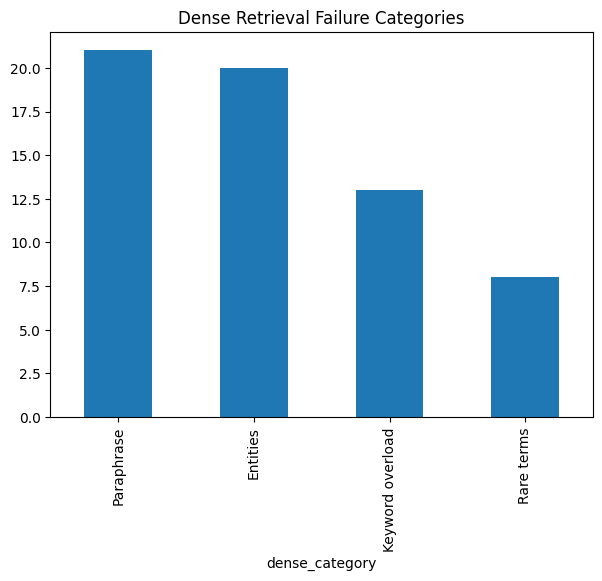

In [125]:
dense_failures = merged_df[merged_df["dense"] == False]

dense_failures["dense_category"].value_counts().plot(
    kind="bar",
    title="Dense Retrieval Failure Categories",
    figsize=(7,5)
)


<Axes: title={'center': 'BM25 Failure Categories'}, xlabel='bm25_category'>

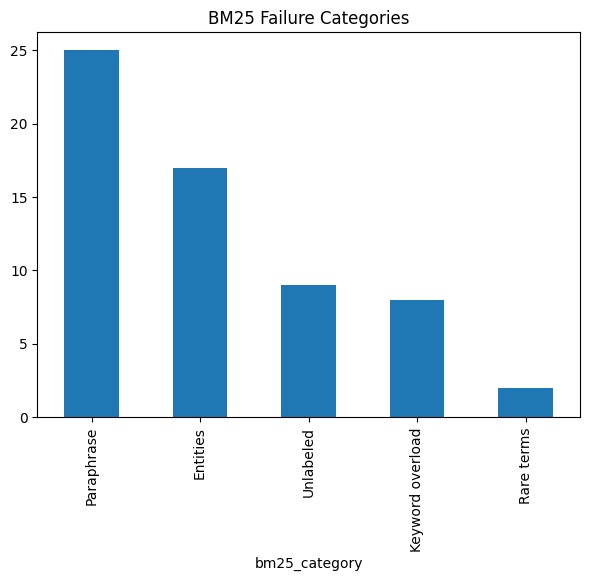

In [126]:
bm25_failures = merged_df[merged_df["bm25"] == False]

bm25_failures["bm25_category"].value_counts().plot(
    kind="bar",
    title="BM25 Failure Categories",
    figsize=(7,5)
)


In [127]:
def outcome(row):
    if not row["dense"] and not row["bm25"]:
        return "Both Fail"
    if not row["dense"] and row["bm25"]:
        return "Dense Only Fail"
    if row["dense"] and not row["bm25"]:
        return "BM25 Only Fail"
    return "Both Succeed"

merged_df["outcome"] = merged_df.apply(outcome, axis=1)

merged_df["outcome"].value_counts()


outcome
Both Succeed       215
Both Fail           38
Dense Only Fail     24
BM25 Only Fail      23
Name: count, dtype: int64

<Axes: title={'center': 'Dense vs BM25 Outcomes'}, xlabel='outcome'>

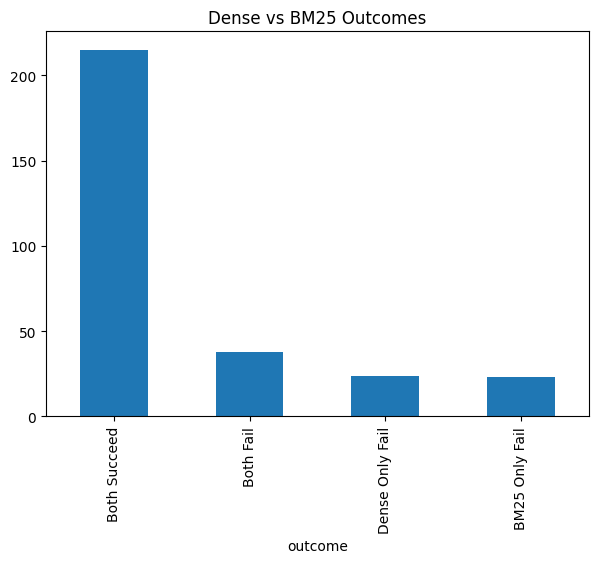

In [128]:
merged_df["outcome"].value_counts().plot(
    kind="bar",
    title="Dense vs BM25 Outcomes",
    figsize=(7,5)
)


In [129]:
confusion = pd.crosstab(
    dense_failures["dense_category"],
    dense_failures["bm25_category"],
    normalize="index"
)

confusion


bm25_category,Entities,Keyword overload,Paraphrase,Unlabeled,not a failure
dense_category,,,,,
Entities,0.200000,0.000000,0.150000,0.150000,0.500000
Keyword overload,0.615385,0.076923,0.076923,0.000000,0.230769
Paraphrase,0.000000,0.142857,0.476190,0.142857,0.238095
Rare terms,0.125000,0.000000,0.125000,0.000000,0.750000


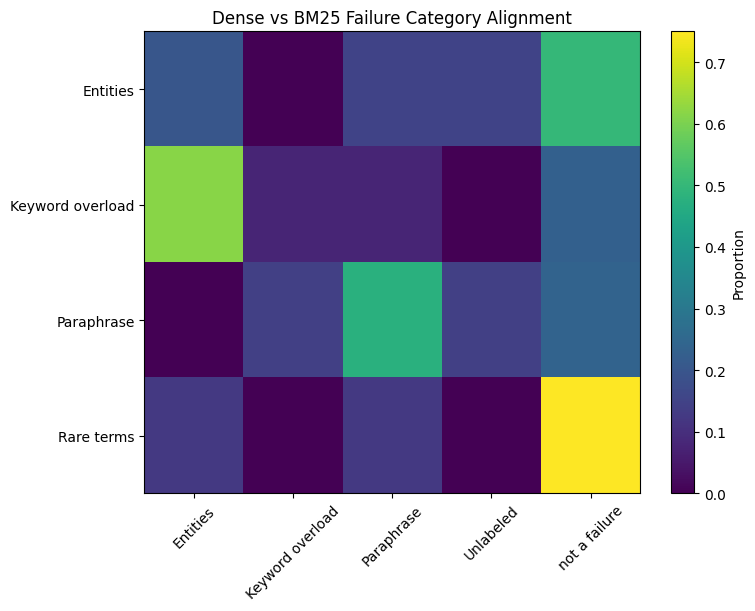

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(confusion, aspect="auto")

plt.xticks(range(len(confusion.columns)), confusion.columns, rotation=45)
plt.yticks(range(len(confusion.index)), confusion.index)

plt.colorbar(label="Proportion")
plt.title("Dense vs BM25 Failure Category Alignment")

plt.show()


In [131]:
#these are dense weaknesses
dense_only = merged_df[
    (merged_df["dense"] == False) &
    (merged_df["bm25"] == True)
]

dense_only["dense_category"].value_counts()


dense_category
Entities            10
Rare terms           6
Paraphrase           5
Keyword overload     3
Name: count, dtype: int64

In [134]:
#these are sparse weaknesses
bm25_only = merged_df[
    (merged_df["dense"] == True) &
    (merged_df["bm25"] == False)
]

bm25_only["bm25_category"].value_counts()


bm25_category
Paraphrase          10
Entities             4
Keyword overload     4
Unlabeled            3
Rare terms           2
Name: count, dtype: int64

In [136]:
both_fail = merged_df[
    (merged_df["dense"] == False) &
    (merged_df["bm25"] == False)
]

both_fail[["qid", "query", "dense_category", "bm25_category"]].head()
both_fail["dense_category"].value_counts()


dense_category
Paraphrase          16
Entities            10
Keyword overload    10
Rare terms           2
Name: count, dtype: int64